In [1]:
import statsmodels
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os

import sklearn
import torch
import torch.nn

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns

DATA_DIR = '../data/'

In [2]:
#The evaluation metrics
def mrse(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)

    denom = np.sqrt(np.sum(np.square(actuals - np.mean(actuals))))
    num = np.sqrt(np.sum(np.square(actuals - preds)))

    return 1.0*num/denom

def re(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    denom = np.sqrt(np.sum(np.square(actuals)))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [3]:
#Reading nino 12
filename = 'nino12_data.txt'
data = open(DATA_DIR + filename)
data_dict = {}

for line in data.readlines()[1:-3]:
    
    tokens = line.split(' ')
    values = []
    for token in tokens:
        if token == '':
            pass
        else:
            if '\n' in token:
                token = token[:-2]
            values.append(float(token))
    data_dict.update({values[0]:values[1:]})

In [4]:
filtered_data = {int(year): data_dict[year] for year in data_dict.keys() if year >= 1950 and year <=2008 }

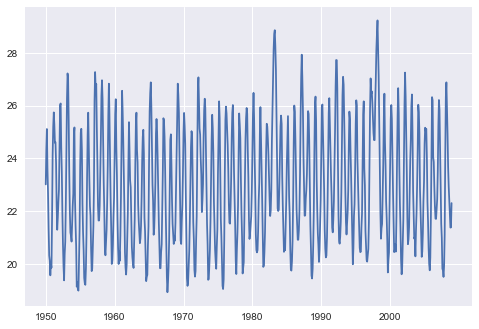

In [5]:
filtered_ts = np.array([])
filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
plt.plot(filtered_ts)
plt.xticks(range(0,708+1,12*10),range(1950,2008+1,10))
plt.show()

In [6]:
def get_data(data,years,subtract_mean=False,means=None):
    if subtract_mean == True:
        assert means is not None
    filtered_data = {int(year): data[year] for year in data.keys() if year in years }
    filtered_ts = np.array([])
    if subtract_mean:
        filtered_ts = np.array([np.concatenate((filtered_ts,val-means)) for val in filtered_data.values()]).flatten()
    else:
        filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
    return filtered_ts

In [7]:
train_test_ratio = 0.8
years = np.array(list(filtered_data.keys()))
print('Total years available')
print(years)
print(f'Train Test ratio: {train_test_ratio}')
training_years = years[:int(train_test_ratio*len(years))]
print(f'No of years in training: {len(training_years)}')
print(training_years)
testing_years = years[int(train_test_ratio*len(years)):]
print(f'No of years in testing: {len(testing_years)}')
print(testing_years)

Total years available
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008]
Train Test ratio: 0.8
No of years in training: 47
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996]
No of years in testing: 12
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]


In [8]:
means = np.zeros(12)
for key,value in filtered_data.items():
    if int(key) in training_years:
        means += np.array(value)
means /= len(training_years)
print(means)

[24.15851064 25.64957447 26.0287234  25.11765957 23.89361702 22.63170213
 21.53702128 20.61957447 20.34978723 20.6412766  21.34446809 22.44255319]


In [9]:
for key,value in filtered_data.items():
    print(key,value-means)
    assert len(value) == 12

1950 [-1.14851064 -1.32957447 -0.9187234  -1.48765957 -1.21361702 -1.30170213
 -1.22702128 -0.49957447 -0.78978723 -0.6512766  -1.49446809 -0.74255319]
1951 [-0.04851064 -0.45957447 -0.2887234   0.17234043  0.69638298  1.97829787
  2.28297872  1.56042553  0.94021277  1.0987234   0.99553191  0.35744681]
1952 [ 0.20148936  0.37042553  0.0512766  -0.67765957 -0.41361702 -0.70170213
 -0.80702128 -0.72957447 -0.97978723 -0.2712766  -0.51446809 -0.14255319]
1953 [-0.02851064  0.62042553  1.1912766   1.88234043  1.53638298  0.79829787
  0.42297872  0.56042553  0.71021277  0.1987234   0.16553191 -0.24255319]
1954 [-1.49851064 -0.76957447 -0.8587234  -2.66765957 -2.46361702 -1.97170213
 -2.40702128 -1.30957447 -1.32978723 -1.6612766  -1.14446809 -1.14255319]
1955 [-0.43851064 -0.67957447 -0.9087234  -0.81765957 -1.63361702 -1.43170213
 -1.01702128 -1.15957447 -1.08978723 -1.4412766  -1.51446809 -1.34255319]
1956 [-0.89851064 -0.74957447 -0.2987234  -0.72765957 -0.68361702 -0.44170213
  0.282978

In [10]:
training_data = get_data(filtered_data,training_years,subtract_mean=True,means=means)
test_data = get_data(filtered_data,testing_years,subtract_mean=True,means=means)
assert len(training_years)*12 == len(training_data)
len(training_data)

564

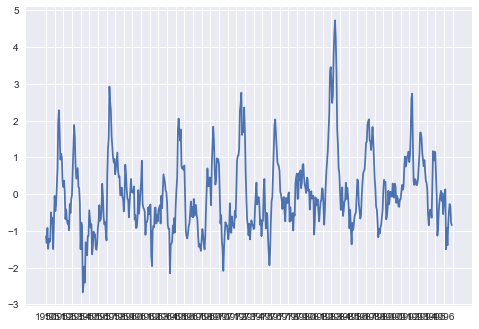

In [11]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),training_years)
plt.show()

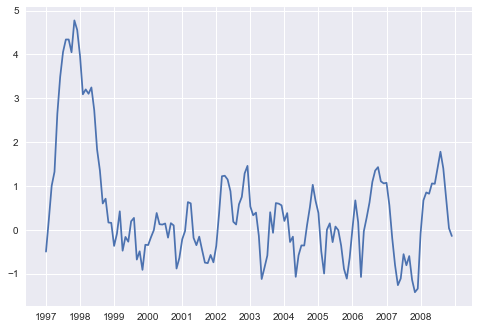

In [12]:
plt.plot(test_data)
plt.xticks(range(0,len(test_data)+1,12),testing_years)
plt.show()

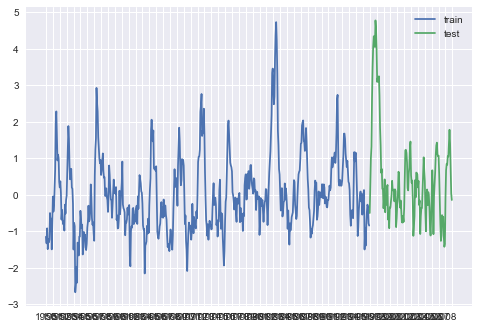

In [13]:
plt.plot(range(0,len(training_data)),training_data,label='train')
plt.plot(range(len(training_data),len(training_data)+len(test_data)),test_data,label='test')
plt.xticks(range(0,len(training_data)+len(test_data)+1,12),list(training_years)+list(testing_years))
plt.legend()
plt.show()

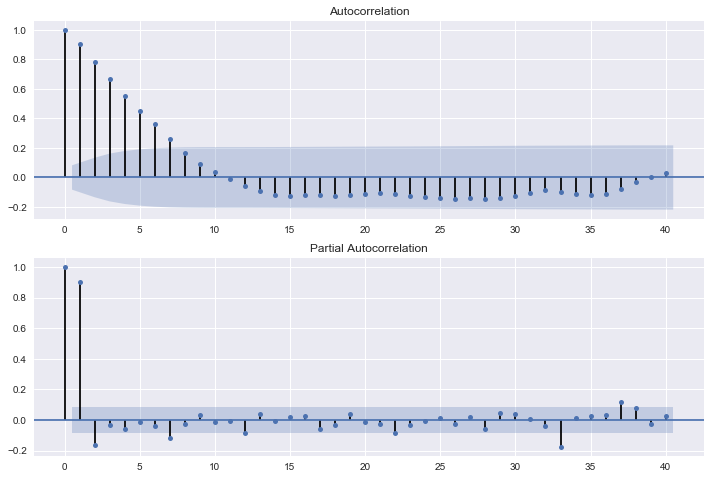

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

In [15]:
formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))

In [16]:
p=5
arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
print(arma_mod.params)

/Users/radhikanikam/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


const     -0.017213
ar.L1.y    1.038867
ar.L2.y   -0.127197
ar.L3.y    0.014365
ar.L4.y   -0.038253
ar.L5.y   -0.013003
dtype: float64


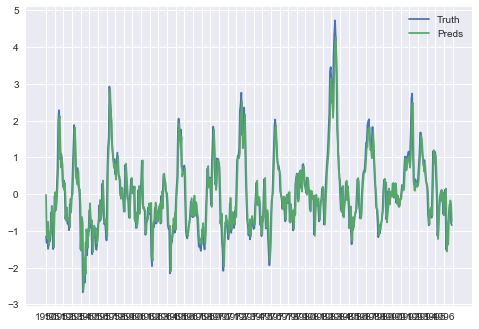

In [17]:
dates = (sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_years)*12))

training_predictions = arma_mod.predict(start=dates[0], 
    end=dates[-1], dynamic=False)
plt.plot(formatted_training_data.values,label='Truth')
plt.plot(training_predictions.values,label='Preds')
plt.xticks(range(0,len(training_data)+1,12),training_years)
plt.legend()
plt.show()

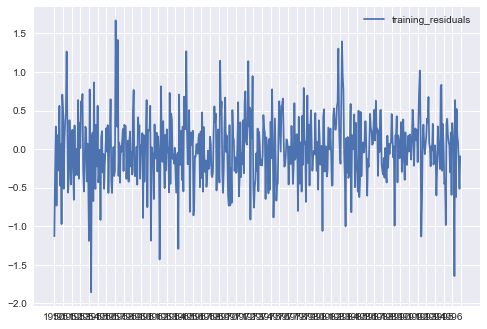

In [18]:
training_residuals = formatted_training_data.values-training_predictions.values
plt.plot(training_residuals,label='training_residuals')
plt.xticks(range(0,len(training_data)+1,12),training_years)
plt.legend()
plt.show()

/Users/radhikanikam/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


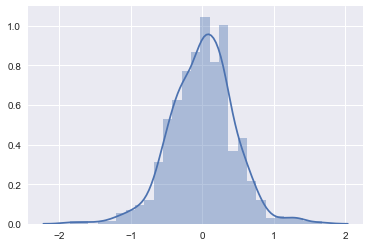

In [19]:
%matplotlib inline
sns.distplot(training_residuals)

In [20]:
history = list(formatted_training_data.values)
test_predictions = []
for t in range(len(test_data)):
    arma_model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = arma_model.forecast()
    yhat = output[0][0]
    test_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)

/Users/radhikanikam/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


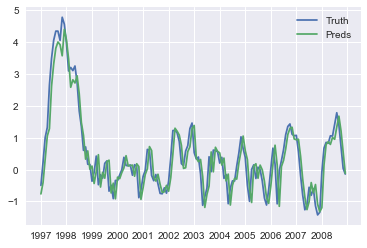

In [21]:
plt.plot(test_data,label='Truth')
plt.plot(test_predictions,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),testing_years)
plt.legend()
plt.show()

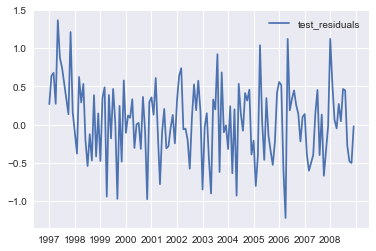

In [22]:
test_residuals = np.array(test_data)-np.array(test_predictions)
plt.plot(test_residuals,label='test_residuals')
plt.xticks(range(0,len(test_data)+1,12),testing_years)
plt.legend()
plt.show()

/Users/radhikanikam/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


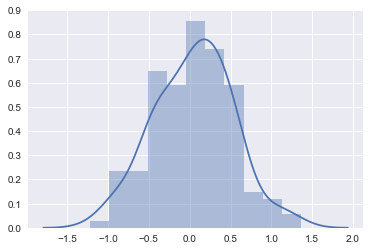

In [23]:
sns.distplot(test_residuals)

In [24]:
def error(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    return np.sqrt(np.mean(np.square(actuals-preds)))


test_mrse = mrse(test_data,test_predictions)
test_re = re(test_data,test_predictions)
test_error = error(test_data,test_predictions)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')

Test MRSE: 0.3782535194390442
Test RE: 0.3566397541346702
Test ERROR: 0.4861011112679275


In [25]:
new_training_data = training_residuals
new_test_data = test_residuals

In [26]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_training_data = scaler.fit_transform(new_training_data.reshape(-1, 1))
scaled_test_data = scaler.transform(new_test_data.reshape(-1, 1))

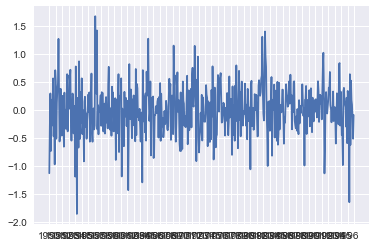

In [27]:
plt.plot(new_training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(new_training_data)+1,12),training_years)
plt.show()

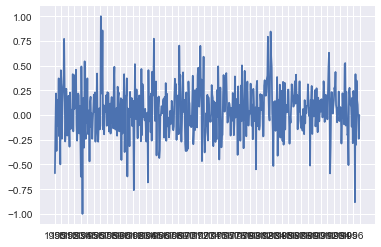

In [28]:
plt.plot(scaled_training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(new_training_data)+1,12),training_years)
plt.show()

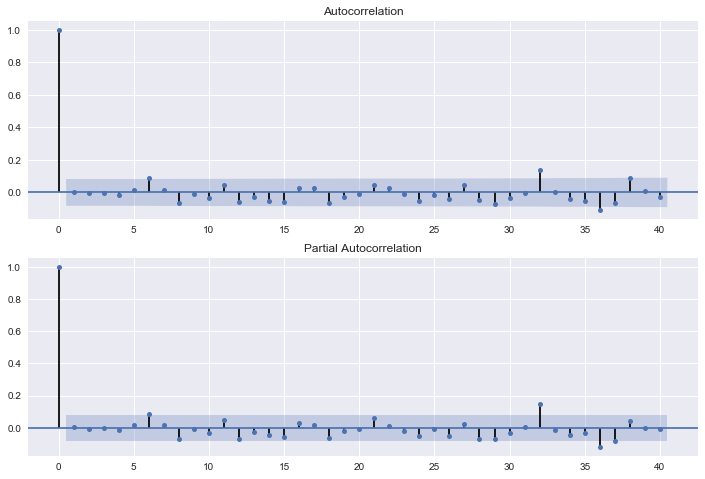

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(scaled_training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(scaled_training_data, lags=40, ax=ax2)
plt.show()

In [30]:
train_data_normalized = torch.FloatTensor(new_training_data).view(-1)
train_window = p

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq[:5]

[(tensor([-1.1313, -0.2914,  0.2914, -0.7334,  0.1798]), tensor([-0.2806])),
 (tensor([-0.2914,  0.2914, -0.7334,  0.1798, -0.2806]), tensor([-0.0580])),
 (tensor([ 0.2914, -0.7334,  0.1798, -0.2806, -0.0580]), tensor([0.5603])),
 (tensor([-0.7334,  0.1798, -0.2806, -0.0580,  0.5603]), tensor([-0.4718])),
 (tensor([ 0.1798, -0.2806, -0.0580,  0.5603, -0.4718]), tensor([0.0599]))]

In [31]:
test_data_normalized = torch.FloatTensor(new_test_data).view(-1)

test_inout_seq = create_inout_sequences(test_data_normalized, train_window)

test_inout_seq[:5]

[(tensor([0.2674, 0.6377, 0.6760, 0.2718, 1.3643]), tensor([0.8705])),
 (tensor([0.6377, 0.6760, 0.2718, 1.3643, 0.8705]), tensor([0.7422])),
 (tensor([0.6760, 0.2718, 1.3643, 0.8705, 0.7422]), tensor([0.5362])),
 (tensor([0.2718, 1.3643, 0.8705, 0.7422, 0.5362]), tensor([0.3409])),
 (tensor([1.3643, 0.8705, 0.7422, 0.5362, 0.3409]), tensor([0.1349]))]

In [32]:
print(f'scaled_training_data: {len(scaled_training_data)}\n\
scaled_test_data: {len(scaled_test_data)}\n\
training_data: {len(new_training_data)}\n\
test_data: {len(new_test_data)}\n\
train_inout_seq: {len(train_inout_seq)}\n\
test_inout_seq: {len(test_inout_seq)}\n\
')

scaled_training_data: 564
scaled_test_data: 144
training_data: 564
test_data: 144
train_inout_seq: 559
test_inout_seq: 139



In [33]:
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_hidden_layers=1, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_hidden_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

#         self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
#                             torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        #lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        lstm_out,_ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [34]:
def evaluate(rescale=True, display_plots=False):
    model.eval()
    scaled_predictions=[]
    scaled_actuals = []
    for i in range(len(test_inout_seq)):
        seq = torch.FloatTensor(test_inout_seq[i][0])
        scaled_actuals.append(test_inout_seq[i][1].item())
        with torch.no_grad():
#             model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
#                             torch.zeros(1, 1, model.hidden_layer_size))
            scaled_predictions.append(model(seq).item())
    if rescale:
        actuals = scaler.inverse_transform(np.array(scaled_actuals).reshape(-1, 1))
        predictions = scaler.inverse_transform(np.array(scaled_predictions).reshape(-1, 1))
    else:
        actuals=scaled_actuals
        predictions=scaled_predictions
    a1 = actuals
    p1 = predictions
    if display_plots:
        plt.plot(actuals,label='Truth')
        plt.plot(predictions,label='Preds')
        plt.xticks(range(0,len(scaled_test_data)+1,12),labels=testing_years)
        plt.legend()
        plt.show()
    test_mrse = mrse(actuals,predictions)
    test_re = re(actuals,predictions)
    test_error = error(actuals,predictions)
    print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')
    return test_mrse,test_re,test_error,a1,p1

In [35]:
def evaluate_r2n2(rescale=True, display_plots=False):
    model.eval()
    scaled_predictions=[]
    scaled_actuals = []
    for i in range(len(test_inout_seq)):
        seq = torch.FloatTensor(test_inout_seq[i][0])
        scaled_actuals.append(test_inout_seq[i][1].item())
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            scaled_predictions.append(model(seq).item())
    if rescale:
        actuals = scaler.inverse_transform(np.array(scaled_actuals).reshape(-1, 1))
        predictions = scaler.inverse_transform(np.array(scaled_predictions).reshape(-1, 1))
        actuals = actuals.reshape(-1)
        predictions = predictions.reshape(-1)
    else:
        actuals=scaled_actuals
        predictions=scaled_predictions
        actuals = np.array(actuals)
        predictions = np.array(predictions)
    a1 = actuals
    p1 = predictions
    actuals = test_data[:-train_window]
    predictions += test_predictions[:-train_window]
    if display_plots:
        plt.plot(actuals,label='Truth')
        plt.plot(predictions,label='Preds')
        plt.xticks(range(0,len(scaled_test_data)+1,12),testing_years)
        plt.legend()
        plt.show()
    test_mrse = mrse(actuals,predictions)
    test_re = re(actuals,predictions)
    test_error = error(actuals,predictions)
    print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')
    return test_mrse,test_re,test_error,a1,p1

In [38]:
layers = [1]
sizes = [8,16,32,64,128]
epochs = 100
loss_function = nn.MSELoss()
input_size=1
output_size=1
skip_cnt = 0
lr_threshold = 1e-5
best_test_metric = np.inf
best_path = None
for a,l in enumerate(layers):
    for b,s in enumerate(sizes):
        if (a*len(sizes))+(b)<skip_cnt:
            print(f'Skipping num_hidden_layers: {l} hidden_layer_size: {s}')
        else:
            num_hidden_layers=l
            hidden_layer_size=s
            
            prev_running_loss = np.inf
            model = LSTM(input_size,hidden_layer_size,num_hidden_layers,output_size)
            print(model)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=4)
            #best_model_params = model.state_dict()
            #PATH = f'models/best_r2n2_model_{p}_{l}_{s}.pth'

            for i in range(epochs):
                running_loss = 0.0
                cnt=0
                for seq, labels in train_inout_seq:
                    optimizer.zero_grad()
            #         model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
            #                         torch.zeros(1, 1, model.hidden_layer_size))

                    y_pred = model(seq)
                    single_loss = loss_function(y_pred, labels)
                    single_loss.backward()
                    optimizer.step()
                    current_loss = single_loss.item()
                    running_loss += current_loss
                current_lr = get_lr(optimizer)
                if current_lr < lr_threshold:
                    print('LR lower than threshold {lr_threshold}. stopping training')
                    break
                    
#                 if running_loss > prev_running_loss:
#                     print('Training loss started to increase. stopping training...')
#                     prev_running_loss = running_loss
#                     cnt += 1
#                     if cnt > 4:   
#                         break
#                 else:
#                     cnt=0
                prev_running_loss = running_loss
                test_mrse,test_re,test_error,a1,p1 = evaluate_r2n2(rescale=False,display_plots=False)
                if i%5 == 1:
                    print(f'epoch: {i:3} loss: {running_loss:10.8f}')
                test_metric = test_error
                scheduler.step(test_error)
                if(test_metric < best_test_metric):
                    count = 0
                    best_test_metric = test_metric
                    #best_path = PATH
                    #torch.save({
                    #    'state_dict': model.state_dict(),
                    #    }, PATH)
                    #print(f"Best Model saved at epoch: {i} with metric: {best_test_metric} num_hidden_layers: {l} hidden_layer_size: {s}")
                else:
                    count+=1
            #     if(count >= 5):
            #         print("Validation has not improved since 5 epochs. Early Stopping...")
            #         break
            print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

LSTM(
  (lstm): LSTM(1, 8)
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Test MRSE: 0.3761376739912356
Test RE: 0.35599411208483916
Test ERROR: 0.4885969966657478
Test MRSE: 0.37629167839448735
Test RE: 0.3561398689833998
Test ERROR: 0.4887970459937071
epoch:   1 loss: 109.28372283
Test MRSE: 0.37632000791798725
Test RE: 0.3561666813562661
Test ERROR: 0.48883384560474347
Test MRSE: 0.37627076529066694
Test RE: 0.3561200758535426
Test ERROR: 0.4887698801966488
Test MRSE: 0.3761646996882324
Test RE: 0.356019690455928
Test ERROR: 0.48863210262640655
Test MRSE: 0.37598950947081483
Test RE: 0.35585388232181125
Test ERROR: 0.4884045332548859
Test MRSE: 0.3757461906627425
Test RE: 0.3556235941347383
Test ERROR: 0.4880884659022197
epoch:   6 loss: 108.51364070
Test MRSE: 0.3754443976839404
Test RE: 0.3553379632847836
Test ERROR: 0.4876964415099464
Test MRSE: 0.375094898834106
Test RE: 0.35500718138941745
Test ERROR: 0.4872424479321289
Test MRSE: 0.37471557979549985
Test RE: 0.

LSTM(
  (lstm): LSTM(1, 32)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


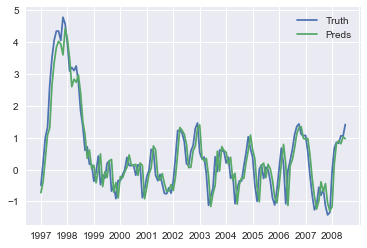

Test MRSE: 0.37519280958025814
Test RE: 0.3550998486534278
Test ERROR: 0.4873696324707145


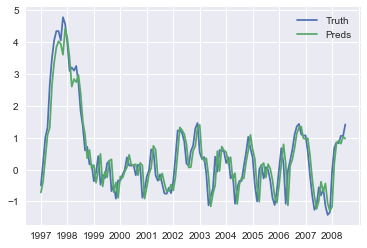

Test MRSE: 0.37501500812663163
Test RE: 0.35493156912444707
Test ERROR: 0.4871386711439139
epoch:   1 loss: 109.24563318


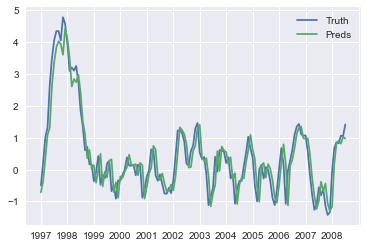

Test MRSE: 0.37495136776417093
Test RE: 0.3548713369384856
Test ERROR: 0.4870560033014852


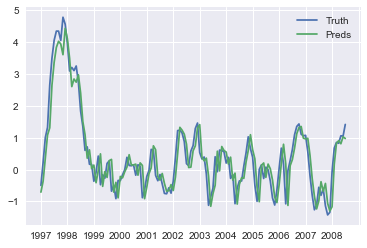

Test MRSE: 0.3749226838607074
Test RE: 0.3548441891640117
Test ERROR: 0.48701874335637985


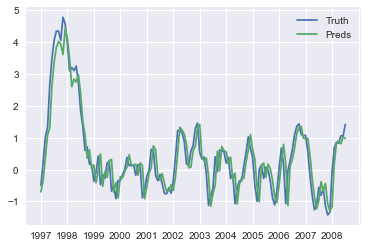

Test MRSE: 0.37490975347270056
Test RE: 0.35483195124604794
Test ERROR: 0.4870019469831828


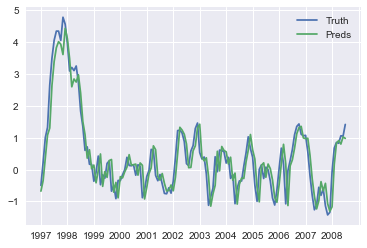

Test MRSE: 0.37493753941737207
Test RE: 0.35485824915074016
Test ERROR: 0.48703804049376354


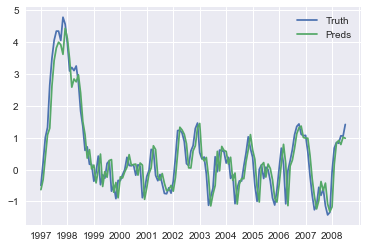

Test MRSE: 0.37509731173971533
Test RE: 0.35500946507501807
Test ERROR: 0.4872455822590403
epoch:   6 loss: 108.21156919


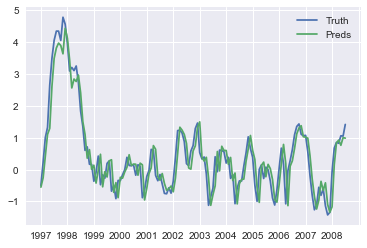

Test MRSE: 0.3754485851264104
Test RE: 0.35534192647424084
Test ERROR: 0.4877018809326791


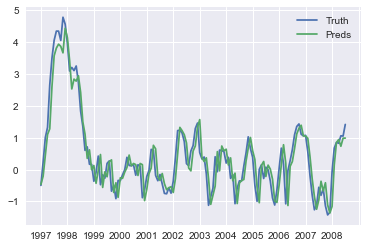

Test MRSE: 0.3762736555620091
Test RE: 0.3561228113401776
Test ERROR: 0.488773634614233


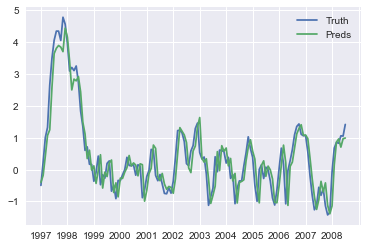

Test MRSE: 0.3777539711486049
Test RE: 0.3575238505587798
Test ERROR: 0.4906965415702245
Epoch     9: reducing learning rate of group 0 to 1.0000e-04.


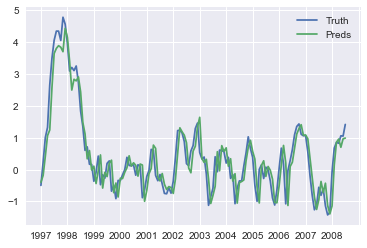

Test MRSE: 0.37770912274149815
Test RE: 0.35748140394954503
Test ERROR: 0.49063828418594


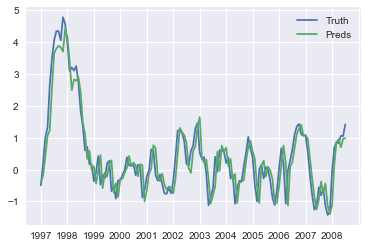

Test MRSE: 0.3775666927741436
Test RE: 0.35734660163308296
Test ERROR: 0.4904532698704469
epoch:  11 loss: 103.07989920


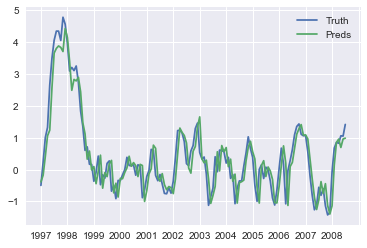

Test MRSE: 0.37736520846087535
Test RE: 0.3571559075490795
Test ERROR: 0.4901915448767936


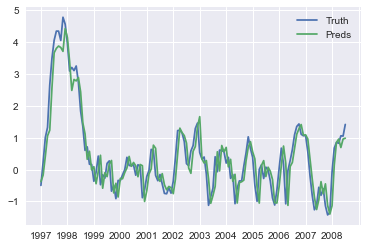

Test MRSE: 0.37712145045875667
Test RE: 0.35692520368842384
Test ERROR: 0.48987490701788233


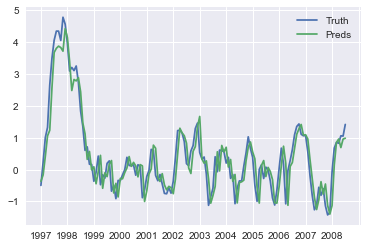

Test MRSE: 0.3768501992310593
Test RE: 0.3566684789659801
Test ERROR: 0.4895225558859457
Epoch    14: reducing learning rate of group 0 to 1.0000e-05.


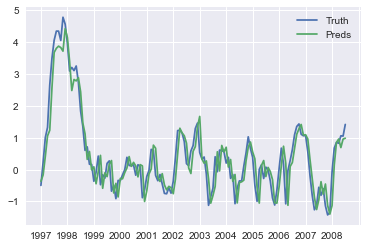

Test MRSE: 0.3768383142384855
Test RE: 0.35665723045866216
Test ERROR: 0.48950711746517994


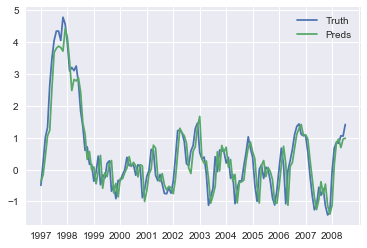

Test MRSE: 0.37682583744548126
Test RE: 0.35664542184401293
Test ERROR: 0.4894909103048463
epoch:  16 loss: 102.27496106


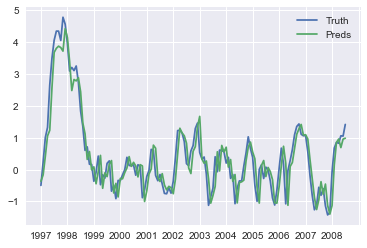

Test MRSE: 0.3768128120764937
Test RE: 0.3566330940316507
Test ERROR: 0.4894739905528303


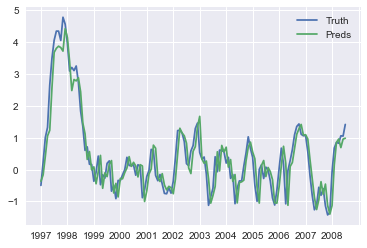

Test MRSE: 0.37679913101381274
Test RE: 0.35662014564041467
Test ERROR: 0.4894562190648904


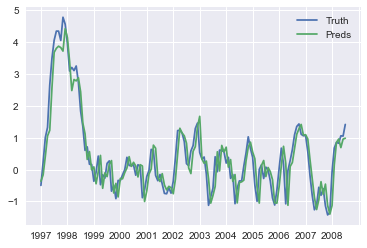

Test MRSE: 0.3767847855019832
Test RE: 0.35660656838373633
Test ERROR: 0.48943758446782604
Epoch    19: reducing learning rate of group 0 to 1.0000e-06.
LR lower than threshold {lr_threshold}. stopping training
epoch:  20 loss: 0.0036513840


In [39]:
layers = [1]
sizes = [32]
epochs = 100
loss_function = nn.MSELoss()
input_size=1
output_size=1
skip_cnt = 0
lr_threshold = 1e-5
best_test_metric = np.inf
best_path = None
for a,l in enumerate(layers):
    for b,s in enumerate(sizes):
        if (a*len(sizes))+(b)<skip_cnt:
            print(f'Skipping num_hidden_layers: {l} hidden_layer_size: {s}')
        else:
            num_hidden_layers=l
            hidden_layer_size=s
            
            prev_running_loss = np.inf
            model = LSTM(input_size,hidden_layer_size,num_hidden_layers,output_size)
            print(model)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=4)
            #best_model_params = model.state_dict()
            #PATH = f'models/best_r2n2_model_{p}_{l}_{s}.pth'

            for i in range(epochs):
                running_loss = 0.0
                cnt=0
                for seq, labels in train_inout_seq:
                    optimizer.zero_grad()
            #         model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
            #                         torch.zeros(1, 1, model.hidden_layer_size))

                    y_pred = model(seq)
                    single_loss = loss_function(y_pred, labels)
                    single_loss.backward()
                    optimizer.step()
                    current_loss = single_loss.item()
                    running_loss += current_loss
                current_lr = get_lr(optimizer)
                if current_lr < lr_threshold:
                    print('LR lower than threshold {lr_threshold}. stopping training')
                    break
                    
#                 if running_loss > prev_running_loss:
#                     print('Training loss started to increase. stopping training...')
#                     prev_running_loss = running_loss
#                     cnt += 1
#                     if cnt > 4:   
#                         break
#                 else:
#                     cnt=0
                prev_running_loss = running_loss
                test_mrse,test_re,test_error,a1,p1 = evaluate_r2n2(rescale=False,display_plots=True)
                if i%5 == 1:
                    print(f'epoch: {i:3} loss: {running_loss:10.8f}')
                test_metric = test_error
                scheduler.step(test_error)
                if(test_metric < best_test_metric):
                    count = 0
                    best_test_metric = test_metric
                    #best_path = PATH
                    #torch.save({
                    #    'state_dict': model.state_dict(),
                    #    }, PATH)
                    #print(f"Best Model saved at epoch: {i} with metric: {best_test_metric} num_hidden_layers: {l} hidden_layer_size: {s}")
                else:
                    count+=1
            #     if(count >= 5):
            #         print("Validation has not improved since 5 epochs. Early Stopping...")
            #         break
            print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')